# Linear and Logistic Regression

We need to import all the libraries we're going to use. `scikit-learn` is slow to load and this section could take a while.

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, precision_score, recall_score
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler

# A random state of 42 is used throughout for reproducibility.
RANDOM_STATE = 42

Let's select the distinct injury severity classes that have been been prepared in the data extraction steps taken earlier.

In [168]:
accidents_df = pd.read_csv('combined_accidents_balanced.csv')
severities = accidents_df['injury_severity'].unique()
severities.sort()
print('The accident severity classes are: ', ', '.join(severities))

The accident severity classes are:  death, grievous, minor, serious


To help visualise our data we can create a bar chart showing the counts for each level of accident severity, grouped by rain condition. To help with visualisation, color values are hard-coded for each severity level.

To remind ourselves, `rain_today` is a boolean column indicating whether there was any amount of rain in the 24 hours preceeding the time of the accident. The boolean `rain_last_3h` is similar, but for the three hours preceeding the accident.

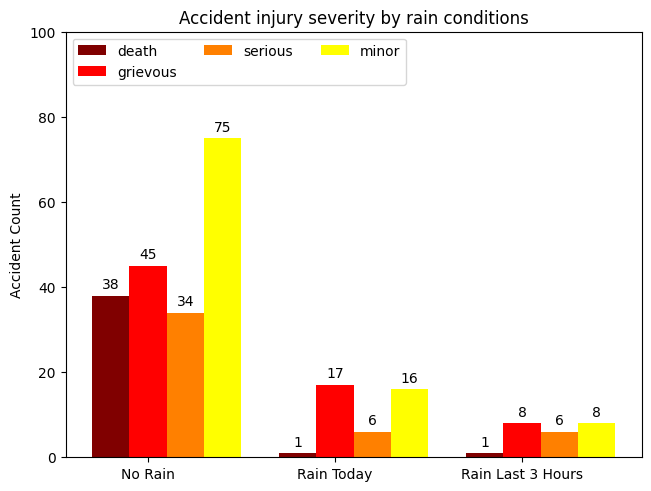

In [169]:
# This dict is keyed by severity and contains a tuple with:
# (number of accidents with no rain, number of accidents with rain today, number of accidents with rain in last 3 hours)
accidents = {}

colours = {'death': '#800000', 'grievous': '#ff0000', 'serious': '#ff8000', 'minor': '#ffff00'}

for severity in colours.keys():
	s_df = accidents_df[accidents_df['injury_severity'] == severity]
	accidents[severity] = (len(s_df.loc[s_df['rain_today']==False]), len(s_df.loc[s_df['rain_today']==True]), len(s_df.loc[s_df['rain_last_3h']==True]))

ncols = 3
x = np.arange(ncols)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for severity, count in accidents.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=severity, color=colours[severity])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accident Count')
ax.set_title('Accident injury severity by rain conditions')
ax.set_xticks(x + width, ('No Rain', 'Rain Today', 'Rain Last 3 Hours'))
ax.legend(loc='upper left', ncols=ncols)
ax.set_ylim(0, 100)

plt.show()

## Linear Regression

Although we intend to focus on logistic regression, let's warm up with multivariate linear regression that uses only `rain_today` and `rain_last_3h` as our *x* values, versus the severity of the injuries in each accident on the *y* axis. The first step is to provide the data.

In [170]:
x = []
y = []

# Map severity levels to a numeric scale of values (higher is more severe; minor is 1 as 0 would imply no injury at all).
SEVERITY_ORDINAL_MAP = {'death': 3, 'grievous': 2, 'serious': 2, 'minor': 1}

# Since our dataset is pretty small, prepare the data for linear regression by iterating through the DataFrame
# rows so that we have more control and less array manipulation.
for i, row in accidents_df.iterrows():
	x.append([1 if row['rain_today'] else 0, 1 if row['rain_last_3h'] else 0])
	y.append(SEVERITY_ORDINAL_MAP[row['injury_severity']])

x = np.array(x)
y = np.array(y)

# An alternative way to set up x and y if we're only interested in one variable vs injury severity:
# x = np.array(accidents_df['rain_today'].astype(int)).reshape(-1, 1)
# y = np.array(accidents_df['injury_severity'].map(severities))


Now let's create the model and fit it.

In [171]:
model = LinearRegression().fit(x, y)

Now that the model is fitted, we can get the results to check whether the model works satisfactorily and to interpret it.

We can obtain the coefficient of determination, 𝑅², with `.score()` called on `model`:

In [172]:
r_sq = model.score(x, y)
print(f"coefficient of determination (𝑅²): {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination (𝑅²): 0.009448168514302191
intercept: 1.8062266105319433
slope: [-0.19571137  0.0340818 ]


As 𝑅² = 0.0094 which is low when when we're only using the rain boolean variables, the relationship is better than the baseline but still weak, or the data is underfitted. Either way, dependencies were not actually captured.

Let's run a routine to identify the most predictive variable. In order to do this we need to prepare the features are nominal numeric, ordinal numeric and categorical. The numerical features are continuous or ordinal values that can be scaled. The categorical features are nominal or binary variables that require encoding.

Let's take a look at the data types of our intended features, to determine which ones require encoding.

In [173]:
features = ['age_min_encoded', 'vehicle_type_score', 'time_period', 'primary_accident_type_code', 'day_of_week_num',
			'rush_hour', 'rain_today', 'rain_last_3h', 'roadworks_nearby', 'affected_party']
print(accidents_df[features].dtypes)

age_min_encoded                int64
vehicle_type_score             int64
time_period                   object
primary_accident_type_code    object
day_of_week_num                int64
rush_hour                      int64
rain_today                      bool
rain_last_3h                    bool
roadworks_nearby                bool
affected_party                object
dtype: object


For both linear and logistic regression, we should convert categorical variables to the categorical data type (since that what they are) and then create dummy variables.

In [174]:
categorical_features = ['time_period', 'primary_accident_type_code', 'affected_party', 'day_of_week_num']
for f in categorical_features:
	accidents_df[f] = accidents_df[f].astype('category')

# One-hot encode categorical features and update our list of features as one-hot encoded columns are created.
encoded_df = pd.get_dummies(accidents_df[features], columns=categorical_features, drop_first=True)
features = encoded_df.keys().array.tolist()

Injury severity is our target for comparison, going on the *y*-axis.

In [175]:
target_feature = 'injury_severity'
encoded_df[target_feature] = accidents_df[target_feature].map(SEVERITY_ORDINAL_MAP)

Prepare the boolean columns which are encoded as strings. `rush_hour` is already encoded as `1` or `0` so there's no need to convert that.

In [176]:
for c in ('rain_today', 'rain_last_3h', 'roadworks_nearby'):
	encoded_df[c] = accidents_df[c].astype(int)

Now, repeat the type check to ensure all features are properly encoded:

In [177]:
display(encoded_df[features].dtypes)

age_min_encoded                     int64
vehicle_type_score                  int64
rush_hour                           int64
rain_today                          int64
rain_last_3h                        int64
roadworks_nearby                    int64
time_period_Evening                  bool
time_period_Morning                  bool
time_period_Night                    bool
primary_accident_type_code_FXOBJ     bool
primary_accident_type_code_OTH       bool
primary_accident_type_code_PED       bool
affected_party_driver                bool
affected_party_motorcyclist          bool
affected_party_pedestrian            bool
day_of_week_num_1                    bool
day_of_week_num_2                    bool
day_of_week_num_3                    bool
day_of_week_num_4                    bool
day_of_week_num_5                    bool
day_of_week_num_6                    bool
dtype: object

Let's identify which feature contributes most significantly to predicting injury severity. In the code below, we iterate through each feature in our dataset and evaluate its predictive power using a linear regression model in conjunction with cross-validation.

In [178]:
y = encoded_df['injury_severity'] # Set injury severity as the target variable.
feature_scores = {}
 
 # For each feature, perform 5-fold cross-validation and calculate R^2 scores.
for feature in features: 
	scores = cross_val_score(LinearRegression(), encoded_df[[feature]], y, cv = KFold(5, shuffle=True, random_state=RANDOM_STATE))
	feature_scores[feature] = scores.mean()
 
# Sort features based on their mean cross-validated R² scores in descending order:
sorted_features = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)

# Print the sorted features and their scores:
feature_imp_df = pd.DataFrame({'Feature': feature_scores.keys(), 'Mean Score': feature_scores.values()})
display(feature_imp_df.sort_values('Mean Score', ascending=False))

,Feature,Mean Score
12,affected_party_driver,0.313885
13,affected_party_motorcyclist,0.108600
9,primary_accident_type_code_FXOBJ,0.027687
11,primary_accident_type_code_PED,0.011590
14,affected_party_pedestrian,0.011590
1,vehicle_type_score,0.003657
10,primary_accident_type_code_OTH,-0.027500
3,rain_today,-0.033767
5,roadworks_nearby,-0.036796
2,rush_hour,-0.044881


Our analysis using linear regression reveals that the affected party feature is the categorical feature with the highest predictability for the severity of an injury in our dataset. This finding highlights the significant danger that cars pose to pedestrians and cyclists. The primary accident type follows somewhat distantly, although still second, highlighting once again that striking a pedestrian as opposed to a fixed object or another car is more likely to result in a severe injury to a person.

## Logistic Regression

In [179]:
x = encoded_df[features]
y = encoded_df[target_feature] # Set injury severity as the target variable.

model = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE).fit(x, y)

Let's test the accuracy of our model, which we can obtain using `.score()`. The returned value is the ratio of the number of correct predictions to the number of observations.

In [180]:
model.score(x, y)

0.7629310344827587

Let's create a heatmap to represent the confusion matrix.

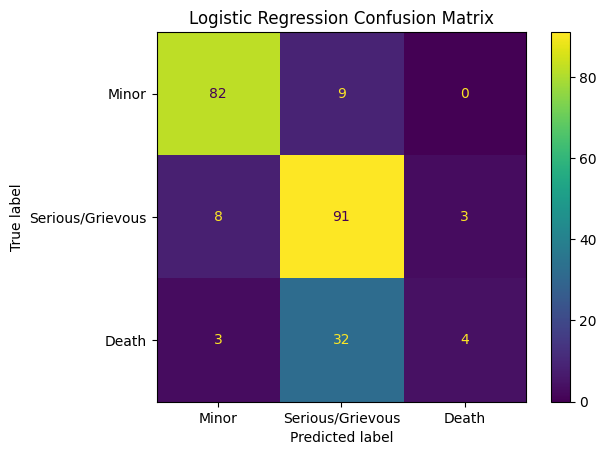

In [181]:
cm = confusion_matrix(y, model.predict(x))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Minor', 'Serious/Grievous', 'Death'])
disp.plot()
disp.ax_.set_title('Logistic Regression Confusion Matrix')
plt.show()

The obtained matrix shows the following in the last test run:

- 82 true minor injury predictions
- 91 true grevious/serious injury predictions
- 4 true death predictions

Let's get a more comprehensive report on the classification with `classification_report()`:

In [182]:
print(classification_report(y, model.predict(x)))

              precision    recall  f1-score   support

           1       0.88      0.90      0.89        91
           2       0.69      0.89      0.78       102
           3       0.57      0.10      0.17        39

    accuracy                           0.76       232
   macro avg       0.71      0.63      0.61       232
weighted avg       0.75      0.76      0.72       232



### Data splitting into train, validation and test

The train (60%) set is for model training, the validation set (20%) is for hyperparameter tuning and the test set (20%) is for the final evaluation of the model performance. Given that the dataset is small, splitting it into three parts negatively affects the modelling process. There is not enough data to train, validate and test.

In [183]:
#splitting data into train, validate and test sets 

def split_stratified_into_train_val_test(df_input, stratify_colname='injury_severity',
										 frac_train=0.7, frac_val=0.15, frac_test=0.15,
										 random_state=42):
	'''
	Splits a Pandas dataframe into three subsets (train, val, and test)
	following fractional ratios provided by the user, where each subset is
	stratified by the values in a specific column (that is, each subset has
	the same relative frequency of the values in the column). It performs this
	splitting by running train_test_split() twice.

	Returns
	-------
	df_train, df_val, df_test :
		Dataframes containing the three splits.
	'''

	if frac_train + frac_val + frac_test != 1.0:
		raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
						 (frac_train, frac_val, frac_test))

	if stratify_colname not in df_input.columns:
		raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

	X = df_input # Contains all columns.
	y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

	# Split original dataframe into train and temp dataframes.
	df_train, df_temp, y_train, y_temp = train_test_split(X,
														  y,
														  stratify=y,
														  test_size=(1.0 - frac_train),
														  random_state=random_state)

	# Split the temp dataframe into val and test dataframes.
	relative_frac_test = frac_test / (frac_val + frac_test)
	df_val, df_test, y_val, y_test = train_test_split(df_temp,
													  y_temp,
													  stratify=y_temp,
													  test_size=relative_frac_test,
													  random_state=random_state)

	assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

	return df_train, df_val, df_test

train, val, test = split_stratified_into_train_val_test(encoded_df, stratify_colname=target_feature, frac_train=0.6, frac_val=0.2, frac_test=0.2)

# Show the number of observations for the train, validate and test dataframes
print('Number of observations in the training set:', len(train))
print('Number of observations in the validate set:',len(val))
print('Number of observations in the test set:',len(test))

Number of observations in the training set: 139
Number of observations in the validate set: 46
Number of observations in the test set: 47


Let's split the data into `X` (features) and `y` (target).

In [184]:
y_train = train[target]
X_train = train[features]

y_val = val[target]
X_val = val[features]

y_test = test[target]
X_test = test[features]

### Baseline Logistic Regression & Cross-Validation
#### Without Class Balancing

f1 score was selected as the main metric to evaluate the model since the target classes are imbalanced (three times fewer fatalities, than other classes, even with reclassifying 20% of grievous injuries to fatalities). It combines Precision and Recall, the latter is defined below. 

Precision = True Positives / (True Positives + False Positives)
F1 score = 2*(Precision * Recall)/Precision + Recall

Balanced accuracy was chosen as another metric since it's suitable for multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

Recall = True Positives / (True Positives + False Negatives)

Accuracy was also used as an additional metric:

Accuracy Score = Number of Correct Predictions / Number of Total Predictions


In [185]:
#Initialising the model with default parameters.
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)

# Cross-validation model
f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores = np.mean(f1_scores)

bal_accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy') #cross-validation over 5 K-fold splits in training data
mean_bal_accuracy = np.mean(bal_accuracy_scores)

accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy') #cross-validation over 5 K-fold splits in training data
mean_accuracy = np.mean(accuracy_scores)

# Train the model on the full training data
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_default = model.predict(X_val)

# Calculate f1_weighted and accuracy on the validation set
f1_scores_val = f1_score(y_val, y_pred_default, average='weighted')
bal_accuracy_val = balanced_accuracy_score(y_val, y_pred_default)
accuracy_val = accuracy_score(y_val, y_pred_default)

# Display results
df_labels = pd.Series(['Imbalanced Train Set CV Mean_f1_scores','Imbalanced Train Set CV Mean Balanced Accuracy', 
                       'Imbalanced Train Set CV Mean Accuracy','Imbalanced Train Set / F1 weighted score Val Set',
                       'Imbalanced Tain Set/ Balanced Accuracy Val Set','Imbalanced Tain Set/ Accuracy Val Set'], name='Performance_Metrics:')
df_values = pd.Series([mean_f1_scores, mean_bal_accuracy,mean_accuracy,f1_scores_val,bal_accuracy_val,accuracy_val],name = 'Performance_Metrics_Values')
df1 = pd.concat([df_labels, df_values], axis =1)
df1

,Performance_Metrics:,Performance_Metrics_Values
0,Imbalanced Train Set CV Mean_f1_scores,0.669151
1,Imbalanced Train Set CV Mean Balanced Accuracy,0.574491
2,Imbalanced Train Set CV Mean Accuracy,0.697884
3,Imbalanced Train Set / F1 weighted score Val Set,0.679256
4,Imbalanced Tain Set/ Balanced Accuracy Val Set,0.606481
5,Imbalanced Tain Set/ Accuracy Val Set,0.717391


The cross-validation (CV) metrics show that the model safficiently generalises over the training set.

#### With Random Oversampling

In [186]:
#the dataset is imbalanced, so let us oversample minority classes to balance the data out
# Method 1. Oversampling of minority classes
ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')

X_res_ros, y_res_ros = ros.fit_resample(X_train, y_train)
y_res_ros.value_counts()

injury_severity
2    61
3    61
1    61
Name: count, dtype: int64

In [187]:
#Initialising the model with default parameters.
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)

# Cross-validation model with oversampled minority class in the training data
f1_scores_res_ros = cross_val_score(model, X_res_ros, y_res_ros, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores_res_ros = np.mean(f1_scores_res_ros)

bal_accuracy_scores_res_ros = cross_val_score(model, X_res_ros, y_res_ros, cv=5, scoring='balanced_accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_bal_accuracy_res_ros = np.mean(bal_accuracy_scores_res_ros)

accuracy_scores_res_ros = cross_val_score(model, X_res_ros, y_res_ros, cv=5, scoring='accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_accuracy_res_ros = np.mean(accuracy_scores_res_ros)

# Train the model on the full training data
model.fit(X_res_ros, y_res_ros)

# Make predictions on the validation set
y_pred_res_ros = model.predict(X_val)

# Calculate f1_weighted, balanced accuracy and accuracy on the validation set
f1_scores_val_res_ros = f1_score(y_val, y_pred_res_ros, average='weighted')
bal_accuracy_val_res_ros = balanced_accuracy_score(y_val, y_pred_res_ros)
accuracy_val_res_ros = accuracy_score(y_val, y_pred_res_ros)

# Display results

df_labels = pd.Series(['Oversampled Train Set CV Mean_f1_scores','OversampledTrain Set CV Mean Balanced Accuracy', 
                       'Oversampled Train Set CV Mean Accuracy','Oversampled Train Set / F1 weighted score Val Set',
                       'Oversampled Tain Set/ Balanced Accuracy Val Set','Oversampled Tain Set/ Accuracy Val Set'], name='Performance_Metrics:')
df2_values = pd.Series([mean_f1_scores_res_ros, mean_bal_accuracy_res_ros,mean_accuracy_res_ros,f1_scores_val_res_ros,bal_accuracy_val_res_ros,accuracy_val_res_ros],name = 'Performance_Metrics_Values')
df2 = pd.concat([df_labels, df2_values], axis =1)
df2

,Performance_Metrics:,Performance_Metrics_Values
0,Oversampled Train Set CV Mean_f1_scores,0.665865
1,OversampledTrain Set CV Mean Balanced Accuracy,0.680342
2,Oversampled Train Set CV Mean Accuracy,0.683033
3,Oversampled Train Set / F1 weighted score Val Set,0.619633
4,Oversampled Tain Set/ Balanced Accuracy Val Set,0.564815
5,Oversampled Tain Set/ Accuracy Val Set,0.630435


#### Baseline Cross Validation (Imbalanced and Oversampled), comparison

In [188]:
df3 = pd.concat([df1.Performance_Metrics_Values, df2.Performance_Metrics_Values,], axis =1)

df3.columns = ['No class balancing', 'Random Oversampling']
df3 = df3.T
df3.columns = ['CV Mean_f1_scores', 'CV Mean_Balanced_Accuracy','CV Mean Accuracy', 'f1_score Val Set', 'Balanced Accuracy Val Set','Accuracy Val Set']
df3

,CV Mean_f1_scores,CV Mean_Balanced_Accuracy,CV Mean Accuracy,f1_score Val Set,Balanced Accuracy Val Set,Accuracy Val Set
No class balancing,0.669151,0.574491,0.697884,0.679256,0.606481,0.717391
Random Oversampling,0.665865,0.680342,0.683033,0.619633,0.564815,0.630435


The metrics show that the training set without class balancing is better at classifying target classes, so I will use it for hyperparameter tuning.

#### Model Training and Hyperparameter Tuning Using the Validation Set

The main hyperparameters we may tune in logistic regression are: solver, penalty, and regularization strength.

We establish a baseline by fitting the classifier with the default parameters before performing the hyperparameter tuning.

In [189]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(model.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(model.score(X_test, y_test)))
print('Precision of logistic regression classifier on test set: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted', zero_division=0)))

Accuracy of logistic regression classifier on train set: 0.7914
Accuracy of logistic regression classifier on test set: 0.7660
Precision of logistic regression classifier on test set: 0.7660


In [190]:
# Adapted from this guide:
# https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69

clf = [
	LogisticRegression(solver='newton-cg', max_iter=1000),
	LogisticRegression(solver='lbfgs',  max_iter=1000),
	LogisticRegression(solver='sag', max_iter=1000),
	LogisticRegression(solver='saga', max_iter=1000)
	]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:
	predicted = alg.fit(X_train, y_train).predict(X_test)
	clf_compare.loc[row_index, 'Solver'] = alg.solver
	clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
	clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
	clf_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted, average='weighted', zero_division=0),5)
	clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted, average='weighted'),5)
	clf_compare.loc[row_index, 'F1 Score'] = round(f1_score(y_test, predicted, average='weighted'),5)
	row_index+=1
	
clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
clf_compare

,Solver,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,newton-cg,0.79137,0.76596,0.76596,0.76596,0.73264
1,lbfgs,0.79137,0.76596,0.76596,0.76596,0.73264
2,sag,0.79137,0.76596,0.76596,0.76596,0.73264
3,saga,0.79137,0.76596,0.76596,0.76596,0.73264


What we observe here is that regardless of the solver we choose, the model metric improvement vs baseline is less than 0.001%.

In [191]:
y_pred_score = model.predict_proba(X_test)

# Calculate metrics on the test set.
f1_scores_test = f1_score(y_test, y_pred, average='weighted')
bal_accuracy_test = balanced_accuracy_score(y_test, y_pred)
accuracy_test = accuracy_score(y_test, y_pred)

print(f"Tuned Model Test Set F1 score: {f1_scores_test:.2f}")
print(f"Tuned Model Test Set Balanced Accuracy: {bal_accuracy_test:.2f}")
print(f"Tuned Model Test Set Accuracy: {accuracy_test:.2f}")

Tuned Model Test Set F1 score: 0.73
Tuned Model Test Set Balanced Accuracy: 0.64
Tuned Model Test Set Accuracy: 0.77


#### Feature Importance Metrics

In [192]:
targets = np.array(['No injury/Minor','Serious/Grievous','Death'])

model_fi = permutation_importance(model, X_test, y_test)
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': model_fi['importances_mean']}).sort_values('Importance', ascending=False)
feature_imp_df

,Feature,Importance
12,affected_party_driver,0.297872
9,primary_accident_type_code_FXOBJ,0.051064
13,affected_party_motorcyclist,0.046809
1,vehicle_type_score,0.042553
16,day_of_week_num_2,0.021277
20,day_of_week_num_6,0.021277
6,time_period_Evening,0.017021
2,rush_hour,0.017021
15,day_of_week_num_1,0.012766
4,rain_last_3h,0.004255


Let's save the results for comparison later on:

In [193]:
dfresults_labels = pd.Series(['F1Score', 'balanced_accuracy', 'accuracy', 'mean fit time'], name='Performance_Metrics:')
dfresults_values = pd.Series([f1_scores_test, bal_accuracy_test, accuracy_test],name = 'LR_Metrics_Values')
df_results = pd.concat([dfresults_labels, dfresults_values], axis =1)
display(df_results)

df_results.to_csv("results/LR_performance_metrics.csv", index=False)

# LR Y test values
y_test.to_csv("results/LR_Ytest.csv", index=False)

# LR Y predicted values
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.to_csv("results/LR_Ypred.csv", index=False)

#Y prediction probabilities for the curve analysis
df_y_pred_score = pd.DataFrame(y_pred_score)
df_y_pred_score.to_csv("results/LR_Y_pred_score.csv", index=False)

#feature importance
feature_imp_df.to_csv("results/LR_Importance.csv", index=False)

,Performance_Metrics:,LR_Metrics_Values
0,F1Score,0.732643
1,balanced_accuracy,0.636905
2,accuracy,0.765957
3,mean fit time,NaN


## Insights

The feature importance results show that the affected party (e.g. pedestrian, cyclist, motorcyclist, driver or passenger) is the most influential feature in predicting injury severity. This indicates that the type of road user involved in an accident plays a central role in determining the outcome.

The model associates car drivers and passengers with minor injuries, particularly in accidents involving similar-sized vehicles. This pattern reflects the protective impact of vehicle safety features, such as seat belts, airbags, and the structural design of modern vehicles. These factors reduce the chances of a severe injury.

In contrast, accidents involving vulnerable road users—including pedestrians, cyclists, and motorcyclists—are much more strongly associated with serious or fatal injuries. This reflects their lack of physical protection and greater exposure to impact forces, which increases injury severity even at lower collision speeds

The primary accident type is the second most important feature, highlighting that the manner in which the accident occurred has a crucial role in influencing severity. Certain accident types, such as run-overs or collisions with fixed objects, inherently involve higher impact forces or limited opportunities to avoid injury, making them more likely to result in severe outcomes. 

The vehicle_type_score also contributes meaningfully to the model’s predictions, particularly for fatal injuries. Fatal outcomes are more likely to occur when vulnerable road users are involved in collisions with larger or heavier vehicles, as these collisions involve greater forces at impact. When vulnerable road users are involved in accidents that do not include large vehicles—such as motorcyclists colliding with fixed objects or pedestrians struck by cars—the model more frequently predicts serious or grievous injuries rather than death

Other contextual features, such as time of day, day of week, and location-related variables, contribute less to the classification outcome. While these factors may influence accident occurrence, they play a smaller role in determining injury severity compared to road user vulnerability and the primary accident type.

Overall, both the linear and logistic regression models highlight that who is involved in the accident and how the accident occurs are the dominant factors influencing injury severity, with vehicle characteristics providing additional context, while temporal and environmental factors have a comparatively limited impact.

## Potential Improvements

With more time, more work could be done to test the importance of the installation of speed cameras. While I did preliminary work to collect speed camera data (see `cameras.py`) our police reports data starts in 2024 and the most recently installed speed camera appears in 2023. A proper conclusion could only potentially be drawn if we were to scrape police reports from earlier than two years ago.